In [1]:
# Init
import glob
import os
import pickle
import sys

module_path = os.path.abspath(os.path.join("../src/simulicronalpha/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import multiprocessing
import warnings

# Imports
import numpy as np
import pandas as pd

np.set_printoptions(suppress=True)
# For loading data
import concurrent.futures
import gc
import json
import random

# Plotting imports
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import figure
from numpy import concatenate as c
from numpy import cumsum

In [20]:
# Acc. functions
def returnLast(lst):
    return lst[-1]


def returnGen(lst):
    return lst[1500]


def returnList(HGTGen, lst):
    return lst[HGTGen]


def colorRanges(i):
    # Construct the colormap
    current_palette = sns.color_palette("muted", n_colors=5)
    cmap = ListedColormap(sns.color_palette(current_palette).as_hex())
    # range and stuff
    if i == 0:
        return "0"
    elif i > 0 and i <= 20:
        return "1-20"
    elif i > 20 and i <= 50:
        return "20-50"
    elif i > 50 and i <= 100:
        return "50-100"
    elif i > 100 and i <= 200:
        return "100-200"
    elif i > 200 and i <= 300:
        return "200-300"
    elif i > 300:
        return ">300"


# Since pickle format is not working as intended.
# Insert angry thoughts abouts pickle format here
# A function to open pickle files and convert into json
def pickleToJson(resultDir):
    for file in glob.glob(os.path.join(resultDir, "*.pickle")):
        with open(file, "rb") as f:
            # print ("Converting file : " + file)
            gc.disable()
            data = pickle.load(f)
            del data["TEset"]
            del data["NTE"]
            del data["NTI"]
            del data["AvgFit"]
            del data["Freq"]
            gc.enable()
            with open(file + ".json", "w") as fp:
                json.dump(data, fp)
    return 0


def bin_by(x, y, nbins=30, bins=None):
    if bins is None:
        bins = np.linspace(x.min(), x.max(), nbins)

    bin_space = (bins[-1] - bins[0]) / (len(bins) - 1) / 2

    indicies = np.digitize(x, bins + bin_space)

    output = []
    for i in range(0, len(bins)):
        output.append(y[indicies == i])
    #
    # prepare a dataframe with cols: median; mean; 1up, 1dn, 2up, 2dn, 3up, 3dn
    df_names = ["mean", "median", "5th", "95th", "10th", "90th", "25th", "75th"]
    df = pd.DataFrame(columns=df_names)
    to_delete = []
    # for each bin, determine the std ranges
    for y_set in output:
        if y_set.size > 0:
            av = y_set.mean()
            intervals = np.percentile(y_set, q=[50, 5, 95, 10, 90, 25, 75])
            res = [av] + list(intervals)
            df = df.append(pd.DataFrame([res], columns=df_names))
        else:
            # just in case there are no elements in the bin
            to_delete.append(len(df) + 1 + len(to_delete))

    # add x values
    bins = np.delete(bins, to_delete)
    df["x"] = bins

    return df


def dfWrangler(dataFrame):
    # Perform some data wrangling
    dataFrame[["TranspositionRate_1", "TranspositionRate_2"]] = pd.DataFrame(
        dataFrame.TRate.tolist(), index=dataFrame.index
    )
    dataFrame[["TE_1_CN", "TE_2_CN"]] = dataFrame["TEfamilyCN"].apply(pd.Series)
    dataFrame[["TE_1_RG", "TE_2_RG"]] = dataFrame["TEfamilyRg"].apply(pd.Series)
    dataFrame[["TE_1_pi", "TE_2_pi"]] = dataFrame["TEpi"].apply(pd.Series)

    # Add column for the last acn (average copy number) for each transposon family
    dataFrame["TE_1_ACN"] = dataFrame["TE_1_CN"].apply(lambda x: returnLast(x))
    dataFrame["TE_2_ACN"] = dataFrame["TE_2_CN"].apply(lambda x: returnLast(x))

    # Add column for copies not present in clusters
    dataFrame["TE_1_NCN"] = dataFrame["TE_1_ACN"] - dataFrame["TE_1_pi"]
    dataFrame["TE_2_NCN"] = dataFrame["TE_2_ACN"] - dataFrame["TE_2_pi"]
    dataFrame["TE_1_NCN_l"] = np.log(dataFrame["TE_1_ACN"] - dataFrame["TE_1_pi"])
    dataFrame["TE_2_NCN_l"] = np.log(dataFrame["TE_2_ACN"] - dataFrame["TE_2_pi"])

    # Add column for nth generation copy number
    dataFrame["TE_1_ACN_N"] = dataFrame["TE_1_CN"].apply(lambda x: returnGen(x))
    dataFrame["TE_2_ACN_N"] = dataFrame["TE_2_CN"].apply(lambda x: returnGen(x))

    # Get ranges for adding colors later
    dataFrame["TE_1_NCN_R"] = dataFrame["TE_1_NCN"].apply(lambda x: colorRanges(x))
    dataFrame["TE_2_NCN_R"] = dataFrame["TE_2_NCN"].apply(lambda x: colorRanges(x))

    return dataFrame


def dfReader(resultDir, suffix):
    # Read the json files into pandas dataframe
    SimulationRecords = []
    for filename in glob.glob(os.path.join(resultDir, suffix)):
        with open(filename, "r") as file:
            SimulationRecords.append(json.load(file))

    SimulationResultsDataFrame = pd.DataFrame(SimulationRecords)

    # Create a copy for inplace handling
    resultDataframe = SimulationResultsDataFrame.copy(deep=True)
    resultDataframe = dfWrangler(resultDataframe)
    return resultDataframe


def plotFrame(
    ax,
    df_1_Alpha,
    df_2_Alpha,
    df_2_Beta,
    TE_1_ACN_1,
    TE_1_ACN_2,
    TE_2_ACN_2,
    ETA_1,
    ETA_2,
):
    cols = ["#EE7550", "#F19463", "#F6B176"]
    """
    # plot the 3rd stdv
    plt.fill_between(
        df_1_Alpha.x, df_1_Alpha["5th"], df_1_Alpha["95th"], alpha=0.1, color=cols[2]
    )
    plt.fill_between(
        df_1_Alpha.x, df_1_Alpha["10th"], df_1_Alpha["90th"], alpha=0.1, color=cols[1]
    )
    plt.fill_between(
        df_1_Alpha.x, df_1_Alpha["25th"], df_1_Alpha["75th"], alpha=0.1, color=cols[0]
    )"""
    # plt the line
    ax.plot(
        df_1_Alpha.x,
        df_1_Alpha["median"],
        color="blue",
        alpha=0.7,
        linewidth=1,
        label="TE α",
    )
    # plot the points
    ax.scatter(
        ETA_1,
        TE_1_ACN_1,
        facecolors="blue",
        edgecolors="0",
        s=5,
        lw=0.7,
        alpha=0.05,
    )

    cols = ["#B31217", "#991014", "#800D11"]
    """
    # plot the 3rd stdv
    plt.fill_between(
        df_2_Alpha.x, df_2_Alpha["5th"], df_2_Alpha["95th"], alpha=0.1, color=cols[2]
    )
    plt.fill_between(
        df_2_Alpha.x, df_2_Alpha["10th"], df_2_Alpha["90th"], alpha=0.1, color=cols[1]
    )
    plt.fill_between(
        df_2_Alpha.x, df_2_Alpha["25th"], df_2_Alpha["75th"], alpha=0.1, color=cols[0]
    )"""
    # plt the line
    ax.plot(
        df_2_Alpha.x,
        df_2_Alpha["median"],
        color="orange",
        alpha=0.7,
        linewidth=1,
        label="TE α (with TE β)",
    )
    # plot the points
    ax.scatter(
        ETA_2,
        TE_1_ACN_2,
        facecolors="orange",
        edgecolors="0",
        s=5,
        lw=0.7,
        alpha=0.05,
    )

    cols = ["#fa9470", "#daae9d", "#ffa591"]
    """
    # plot the 3rd stdv
    plt.fill_between(
        df_2_Beta.x, df_2_Beta["5th"], df_2_Beta["95th"], alpha=0.1, color=cols[2]
    )
    plt.fill_between(
        df_2_Beta.x, df_2_Beta["10th"], df_2_Beta["90th"], alpha=0.1, color=cols[1]
    )
    plt.fill_between(
        df_2_Beta.x, df_2_Beta["25th"], df_2_Beta["75th"], alpha=0.1, color=cols[0]
    )"""
    # plt the line
    ax.plot(
        df_2_Beta.x,
        df_2_Beta["median"],
        color="green",
        alpha=0.7,
        linewidth=1,
        label="TE β (with TE α)",
    )
    # plot the points
    ax.scatter(
        ETA_2,
        TE_2_ACN_2,
        facecolors="green",
        edgecolors="0",
        s=5,
        lw=0.7,
        alpha=0.05,
    )

    return ax

In [3]:
# Path to results
resultDir = "/home/siddharth/git/Simulicron/Project_1C/coreSim/"

# Convert them to json
# returnValue = pickleToJson(resultDir)

In [4]:
resultDataframe_1 = dfReader(resultDir, "*_5.pickle.json")
resultDataframe_2 = dfReader(resultDir, "*_2.pickle.json")
resultDataframe_3 = dfReader(resultDir, "*_6.pickle.json")
resultDataframe_4 = dfReader(resultDir, "*_3.pickle.json")

/home/siddharth/mambaforge/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
# Extract data
# For #1 TE
TE_1_ACN_1_n = np.asarray(resultDataframe_3["TE_1_ACN"].tolist())
ETA_1 = np.asarray(resultDataframe_3["ETA"].tolist())


# For #2 TE
TE_1_ACN_2_n = np.asarray(resultDataframe_4["TE_1_ACN"].tolist())
TE_2_ACN_2_n = np.asarray(resultDataframe_4["TE_2_ACN"].tolist())
ETA_2 = np.asarray(resultDataframe_4["ETA"].tolist())

# Process them
# Alpha
df_1_Alpha_n = bin_by(ETA_1, TE_1_ACN_1_n, nbins=25, bins=None)
# Alpha+Beta
df_2_Alpha_n = bin_by(ETA_2, TE_1_ACN_2_n, nbins=25, bins=None)
df_2_Beta_n = bin_by(ETA_2, TE_2_ACN_2_n, nbins=25, bins=None)

In [6]:
# Extract data
# For #1 TE
TE_1_ACN_1_e = np.asarray(resultDataframe_1["TE_1_ACN"].tolist())
epistasisCoefficient_1 = np.asarray(resultDataframe_1["epistasisCoefficient"].tolist())


# For #2 TE
TE_1_ACN_2_e = np.asarray(resultDataframe_2["TE_1_ACN"].tolist())
TE_2_ACN_2_e = np.asarray(resultDataframe_2["TE_2_ACN"].tolist())

epistasisCoefficient_2 = np.asarray(resultDataframe_2["epistasisCoefficient"].tolist())

# Process them
# Alpha
df_1_Alpha_e = bin_by(epistasisCoefficient_1, TE_1_ACN_1_e, nbins=25, bins=None)
# Alpha+Beta
df_2_Alpha_e = bin_by(epistasisCoefficient_2, TE_1_ACN_2_e, nbins=25, bins=None)
df_2_Beta_e = bin_by(epistasisCoefficient_2, TE_2_ACN_2_e, nbins=25, bins=None)

In [ ]:
"""    ax,
    df_1_Alpha,
    df_2_Alpha,
    df_2_Beta,
    TE_1_ACN_1,
    TE_1_ACN_2,
    TE_2_ACN_2,
    ETA_1,
    ETA_2,
):"""

<Figure size 432x288 with 0 Axes>

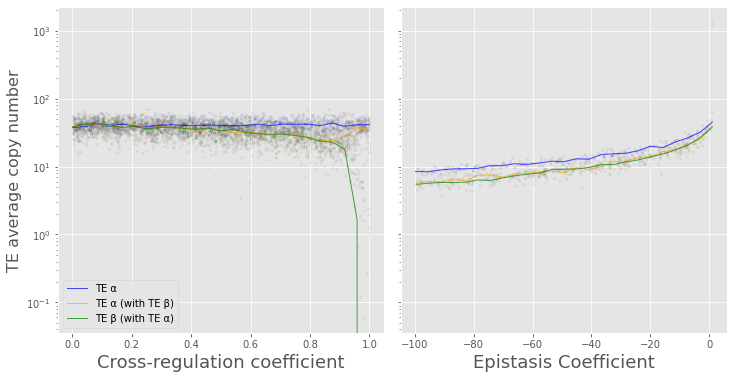

In [38]:
with plt.style.context('ggplot'):
    plt.clf()
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.05, hspace=0)
    ax1 = plotFrame(
        ax1,
        df_1_Alpha_n,
        df_2_Alpha_n,
        df_2_Beta_n,
        TE_1_ACN_1_n,
        TE_1_ACN_2_n,
        TE_2_ACN_2_n,
        ETA_1,
        ETA_2,
    )
    ax1.set_yscale("log")
    ax1.set_xlabel("Cross-regulation coefficient", fontsize=18)
    ax1.set_ylabel("TE average copy number", fontsize=16)
    ax1.legend(loc="lower left")


    ax2 = plotFrame(
        ax2,
        df_1_Alpha_e,
        df_2_Alpha_e,
        df_2_Beta_e,
        TE_1_ACN_1_e,
        TE_1_ACN_2_e,
        TE_2_ACN_2_e,
        epistasisCoefficient_1,
        epistasisCoefficient_2,
    )
    ax2.set_yscale("log")
    ax2.set_xlabel("Epistasis Coefficient", fontsize=18)
    plt.savefig("CrossEpiBase.svg", bbox_inches = "tight")
    plt.savefig("CrossEpiBase.pdf", bbox_inches = "tight")
# ax2.ylabel("TE average copy number", fontsize=16)
# ax2.legend(loc="upper left")

In [22]:
ax2

<AxesSubplot:xlabel='Epistasis Coefficient'>